<a href="https://colab.research.google.com/github/MariiaKalinina/Elasticity/blob/main/Tver_elastisity_update_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
from math import *
from scipy import integrate
from numpy import linalg as LA
import matplotlib.pyplot as plt
%matplotlib inline
from numba import njit
import numpy as np
from scipy.integrate import dblquad

import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
import matplotlib.colors

import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
%matplotlib inline
csfont = {'fontname':'Times New Roman'}

# Preparation part

In [2]:
path_to_ser = Path('/content/Tver.xlsx')
df_ues = pd.read_excel(path_to_ser, sheet_name='All properties', skiprows=0)

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [4]:
data = df_ues.copy()
data.drop('#', axis=1, inplace=True)

In [5]:
data[:5]

,Sample,Well,Litholohy,"Porosity,%",Permeability,Density (water),Density (oil),Vp air,Vs air,Vp oil,Vs oil,Vp water,Vs water,Unnamed: 14,AR thermal,AO electrical
0,113480,a,"пористо-кавернозный, скол на торце, закрытые и полуоткрытые трещины",4.524900,0.832741,2.572247,2.576227,5.037000,2.360000,5.564425,3.019440,5.2945,2.6495,NaN,0.066681,0.069183
1,113532,a,пористо-кавернозный,6.473371,0.253703,2.537162,2.529374,4.042333,2.427667,5.173550,2.849075,5.0545,2.6650,NaN,0.134276,0.087096
2,113536,a,пористо-кавернозный,15.024288,18.334600,2.285245,2.297374,3.514333,1.997000,4.103260,2.256210,4.0285,2.2330,NaN,0.131826,0.104713
3,113541,a,пористо-кавернозный,14.192654,17.343900,2.326067,2.319278,3.241000,1.837667,3.971235,2.164210,3.8155,2.0285,NaN,0.122462,0.095499
4,113556,a,пористо-кавернозный,9.432966,15.777000,2.459785,2.445896,3.798667,2.336333,4.759910,2.564645,4.8270,2.5030,NaN,0.081658,0.072444


In [6]:
data[['Vp air', 'Vs air', 'Vp water', 'Vs water', 'Vp oil', 'Vs oil']].describe()

,Vp air,Vs air,Vp water,Vs water,Vp oil,Vs oil
count,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000
mean,4.049354,2.347747,4.734121,2.500788,4.801224,2.647978
std,0.785375,0.394807,0.634691,0.349465,0.684056,0.374006
min,2.212333,1.323000,3.259500,1.718500,3.167705,1.825235
25%,3.514333,2.076667,4.405000,2.233000,4.224880,2.373170
50%,4.042333,2.360000,4.900000,2.582000,4.972040,2.704390
75%,4.839333,2.675000,5.211500,2.723500,5.190400,2.876360
max,5.199333,2.883000,5.674000,2.991500,5.958540,3.269995


In [7]:
data['Vp/Vs air'] = data[['Vp air', 'Vs air']].apply(lambda x: x[0]/x[1], axis=1)
data['Vp/Vs water'] = data[['Vp water', 'Vs water']].apply(lambda x: x[0]/x[1], axis=1)
data['Vp/Vs oil'] = data[['Vp oil', 'Vs oil']].apply(lambda x: x[0]/x[1], axis=1)

data['Vp Water/Oil Diff'] = data[['Vp water', 'Vp oil']].apply(lambda x: np.round((x[0]-x[1])/x[1]*100, 2), axis=1)
data['Vs Water/Oil Diff'] = data[['Vs water', 'Vs oil']].apply(lambda x: np.round((x[0]-x[1])/x[1]*100, 2), axis=1)

In [8]:
def bulk_mdl(p, vp, vs):

    K = list(map(lambda x, y, z: x * (y**2 - 4/3*z**2), p, vp, vs))
    μ = list(map(lambda x, z: x * z**2, p, vs))
    return K[0], μ[0]

In [9]:
    ### Moduli Air
data['K air'] = data[['Vp air', 'Vs air', 'Density (water)']].apply(lambda x: x[2] * (x[0]**2 - 4/3*x[1]**2), axis=1)
data['Mu air'] = data[['Vs air', 'Density (water)']].apply(lambda x: x[1] * x[0]**2, axis=1)

    ### Moduli Water
data['K water'] = data[['Vp water', 'Vs water', 'Density (water)']].apply(lambda x: x[2] * (x[0]**2 - 4/3*x[1]**2), axis=1)
data['Mu water'] = data[['Vs water', 'Density (water)']].apply(lambda x: x[1] * x[0]**2, axis=1)

    ### Moduli Oil
data['K oil'] = data[['Vp oil', 'Vs oil', 'Density (oil)']].apply(lambda x: x[2] * (x[0]**2 - 4/3*x[1]**2), axis=1)
data['Mu oil'] = data[['Vs oil', 'Density (oil)']].apply(lambda x: x[1] * x[0]**2, axis=1)

In [10]:
data[:5]

,Sample,Well,Litholohy,"Porosity,%",Permeability,Density (water),Density (oil),Vp air,Vs air,Vp oil,Vs oil,Vp water,Vs water,Unnamed: 14,AR thermal,AO electrical,Vp/Vs air,Vp/Vs water,Vp/Vs oil,Vp Water/Oil Diff,Vs Water/Oil Diff,K air,Mu air,K water,Mu water,K oil,Mu oil
0,113480,a,"пористо-кавернозный, скол на торце, закрытые и полуоткрытые трещины",4.524900,0.832741,2.572247,2.576227,5.037000,2.360000,5.564425,3.019440,5.2945,2.6495,NaN,0.066681,0.069183,2.134322,1.998302,1.842867,-4.85,-12.25,46.159570,14.326384,48.028807,18.056785,48.450587,23.487506
1,113532,a,пористо-кавернозный,6.473371,0.253703,2.537162,2.529374,4.042333,2.427667,5.173550,2.849075,5.0545,2.6650,NaN,0.134276,0.087096,1.665111,1.896623,1.815870,-2.30,-6.46,21.521152,14.952932,40.793349,18.019497,40.324913,20.531503
2,113536,a,пористо-кавернозный,15.024288,18.334600,2.285245,2.297374,3.514333,1.997000,4.103260,2.256210,4.0285,2.2330,NaN,0.131826,0.104713,1.759806,1.804075,1.818652,-1.82,-1.03,16.072570,9.113578,21.893623,11.394892,23.087306,11.694747
3,113541,a,пористо-кавернозный,14.192654,17.343900,2.326067,2.319278,3.241000,1.837667,3.971235,2.164210,3.8155,2.0285,NaN,0.122462,0.095499,1.763650,1.880947,1.834958,-3.92,-6.27,13.959632,7.855171,21.101203,9.571328,22.092591,10.863045
4,113556,a,пористо-кавернозный,9.432966,15.777000,2.459785,2.445896,3.798667,2.336333,4.759910,2.564645,4.8270,2.5030,NaN,0.081658,0.072444,1.625910,1.928486,1.855972,1.41,-2.40,17.592209,13.426620,36.765377,15.410573,33.965842,16.087646


In [11]:
data[['Vp Water/Oil Diff', 'Vs Water/Oil Diff']].describe()

,Vp Water/Oil Diff,Vs Water/Oil Diff
count,33.000000,33.000000
mean,-1.018788,-5.234242
std,7.620490,8.221110
min,-21.120000,-24.470000
25%,-4.850000,-10.100000
50%,-1.770000,-6.180000
75%,1.840000,-2.400000
max,31.430000,25.300000


Text(0, 0.5, 'Absolute Percentage Error, %')

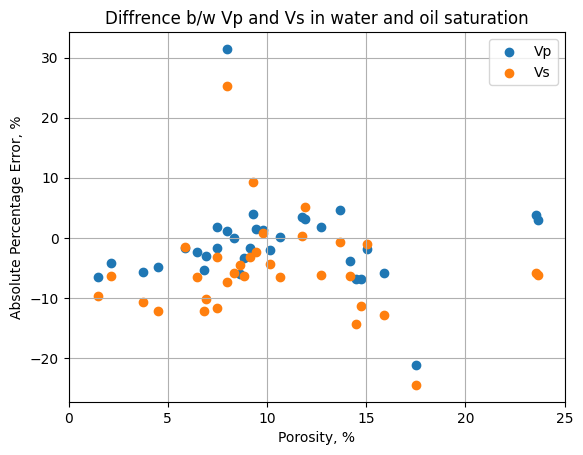

In [12]:
plt.scatter(data['Porosity,%'], data['Vp Water/Oil Diff'], label='Vp')
plt.scatter(data['Porosity,%'], data['Vs Water/Oil Diff'], label='Vs')
plt.title('Diffrence b/w Vp and Vs in water and oil saturation')
plt.legend()
plt.grid()
plt.xlim(0, 25)
plt.xlabel('Porosity, %')
plt.ylabel('Absolute Percentage Error, %')

$Susan, 1992$
https://www.crewes.org/Documents/ResearchReports/1992/1992-12.pdf

https://www.researchgate.net/publication/249866305_Changes_in_dynamic_shear_moduli_of_carbonate_rocks_with_fluid_substitution

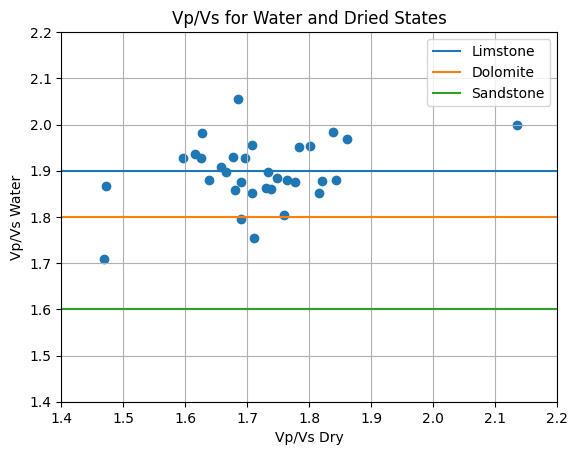

In [13]:
plt.scatter(data['Vp/Vs air'], data['Vp/Vs water'])
plt.plot([0, 25], [1.9, 1.9], label='Limstone')
plt.plot([0, 25], [1.8, 1.8], label='Dolomite')
plt.plot([0, 25], [1.6, 1.6], label='Sandstone')
plt.xlim(1.4, 2.2)
plt.ylim(1.4, 2.2)
plt.title('Vp/Vs for Water and Dried States')
plt.xlabel('Vp/Vs Dry')
plt.ylabel('Vp/Vs Water')
plt.legend()
plt.grid()

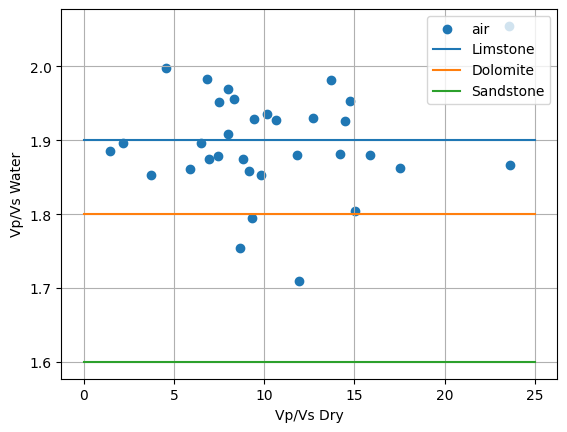

In [14]:
# plt.scatter(data['Porosity,%'], data['Vp/Vs air'], label='air')
plt.scatter(data['Porosity,%'], data['Vp/Vs water'], label='air')
plt.plot([0, 25], [1.9, 1.9], label='Limstone')
plt.plot([0, 25], [1.8, 1.8], label='Dolomite')
plt.plot([0, 25], [1.6, 1.6], label='Sandstone')
# plt.xlim(1.4, 2.2)
# plt.ylim(1.4, 2.2)
plt.xlabel('Vp/Vs Dry')
plt.ylabel('Vp/Vs Water')
plt.legend()
plt.grid()

### Vp, Vs, density of minerals
- Calcite Peselnick and Robie (1963) Vp=6.54 Vs=3.35, p=2.71
- Dolomite Ahrens (1995) Vp=6.40; Vs=3.46 p=2.86

In [15]:
def bulk_mdl(p, vp, vs):

    K = list(map(lambda x, y, z: x * (y**2 - 4/3*z**2), p, vp, vs))
    μ = list(map(lambda x, z: x * z**2, p, vs))
    return K[0], μ[0]

In [16]:
### Calcite. (Известняк состоит преимущественно из кальцита)
K_calcite, mu_calcite = bulk_mdl([2.71], [6.54], [3.35])

### Dolomite
K_dolomite, mu_dolomite = bulk_mdl([2.86], [6.40], [3.46])

In [17]:
K_calcite, mu_calcite

(75.36040266666667, 30.412975)

In [18]:
K_dolomite, mu_dolomite

(71.49389866666668, 34.238776)

In [19]:
K_oil, Mu_oil, p_oil = 0.26, 10**-12, 1.04
K_water, Mu_water, p_water = 2.25, 10**-20, 1.04 ### water
K_air, Mu_air, p_air = 10**-6, 10**-6, 1.22 ### air

### Voight and Hashin-Strikman boundes

In [20]:
def HS_borders(K, μ, f):

  K_up = K[0] + (f[1]/((K[1]-K[0])**-1 + f[0]*(K[0]+4/3*μ[0])**-1))
  K_lo = K[1] + (f[0]/((K[0]-K[1])**-1 + f[1]*(K[1]+4/3*μ[1])**-1))
  K_av = np.mean([K_up, K_lo])

  μ_up = μ[0] + ((f[1])/((μ[1]-μ[0])**-1 + 2*f[0]*(K[0]+2*μ[0])/(5*μ[0]*(K[0]+4/3*μ[0]))))
  μ_lo = μ[1] + ((f[0])/((μ[0]-μ[1])**-1 + 2*f[1]*(K[1]+2*μ[1])/(5*μ[1]*(K[1]+4/3*μ[1]))))
  μ_av = np.mean([μ_up, μ_lo])

  return K_up, K_lo, K_av, μ_up, μ_lo, μ_av

In [21]:
K_matrix, Mu_matrix = K_calcite, mu_calcite

In [22]:
K_fluid, Mu_fluid = K_air, Mu_air

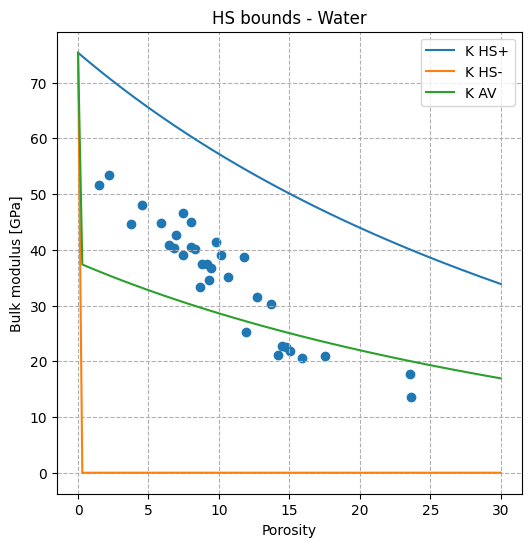

In [23]:
porosity = np.linspace(0, 0.3, 100, endpoint=True)
K_up_value, K_lo_value, K_av_value = [], [], []


for phi in porosity:
  K, μ, f = [K_matrix, K_fluid], [Mu_matrix, Mu_fluid], [1-phi, phi]
  K_up, K_lo, K_av, _, _, _ = HS_borders(K, μ, f)
  K_up_value.append(K_up)
  K_lo_value.append(K_lo)
  K_av_value.append(K_av)



plt.figure(figsize=(6,6))
plt.xlabel('Porosity')
plt.ylabel('Bulk modulus [GPa]')
plt.title('HS bounds - Water')

plt.plot(porosity*100, K_up_value,label='K HS+')
plt.plot(porosity*100, K_lo_value,label='K HS-')
plt.plot(porosity*100, K_av_value,label='K AV')

plt.scatter(data['Porosity,%'], data['K water'])

plt.legend(loc='best')
plt.grid(ls='--')

HS bourders for K and Mu moduli in diffrent saturation states.
--> All samples are inside bourdes for which Calcite moduli K and mu were used.

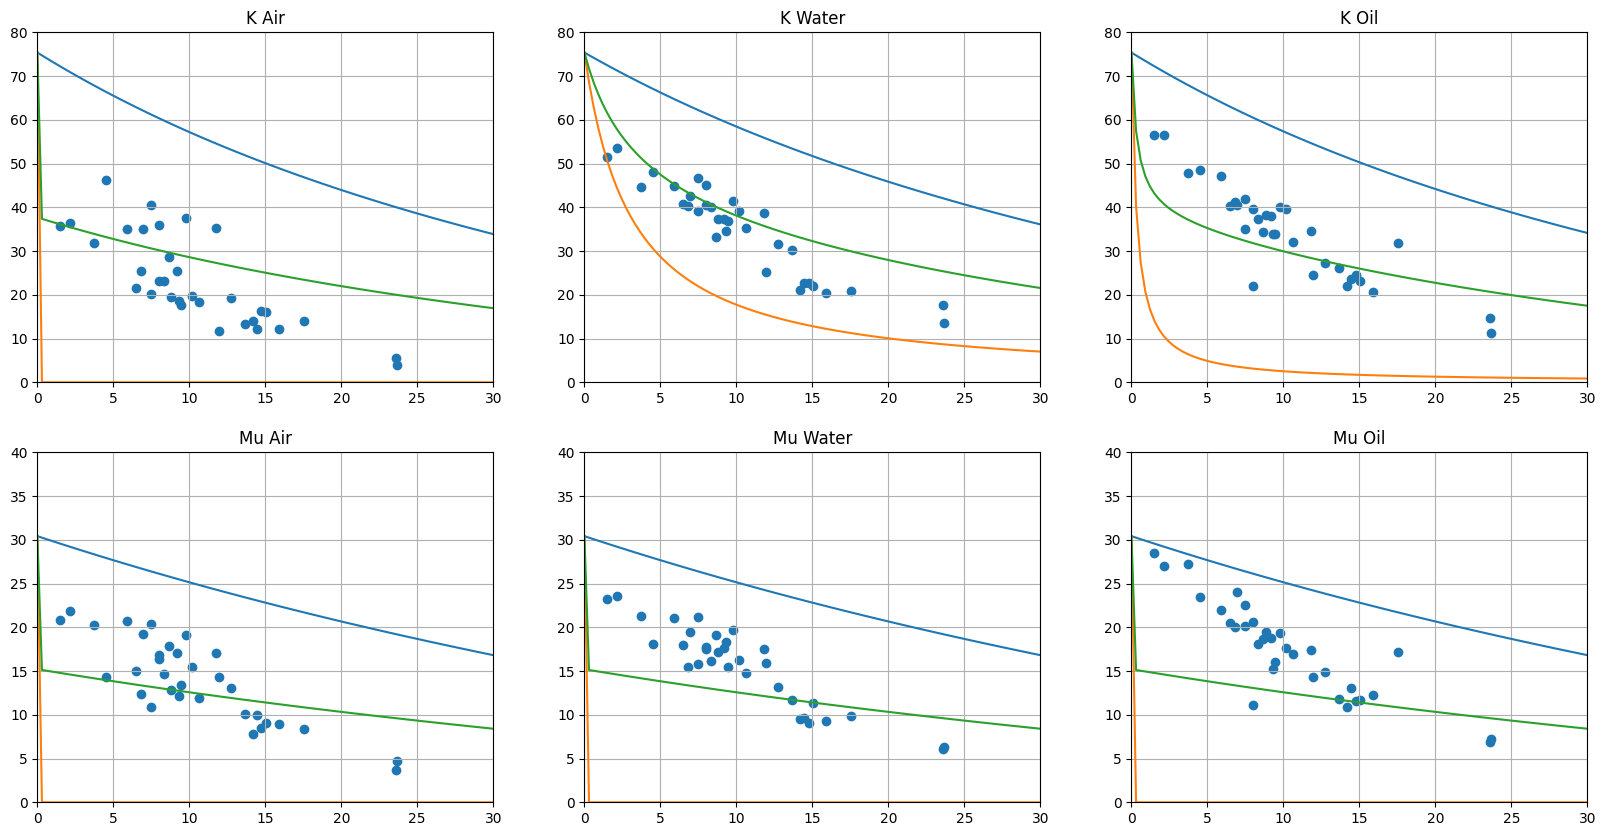

In [ ]:
fig = plt.figure(figsize=(20, 10))

porosity = np.linspace(0, 0.3, 100, endpoint=True)

K_matrix, Mu_matrix = K_calcite, mu_calcite

MODULI = {
    "K Air": [data['K air'], K_matrix, K_air, Mu_matrix, Mu_air],
    "K Water":[data['K water'], K_matrix, K_water, Mu_matrix, Mu_water],
    "K Oil" : [data['K oil'],K_matrix, K_oil, Mu_matrix, Mu_oil],
    "Mu Air" : [data['Mu air'], K_matrix, K_air, Mu_matrix, Mu_air],
     "Mu Water" : [data['Mu water'], K_matrix, K_water, Mu_matrix, Mu_water],
     "Mu Oil" : [data['Mu oil'], K_matrix, K_oil, Mu_matrix, Mu_oil]
}

for index, (name, moduli) in enumerate(MODULI.items()):

  K_matrix, K_fluid, Mu_matrix, Mu_fluid = moduli[1], moduli[2], moduli[3], moduli[4]

  K_up_value, K_lo_value, K_av_value = [], [], []
  Mu_up_value, Mu_lo_value, Mu_av_value = [], [], []

  for phi in porosity:
    K, μ, f = [K_matrix, K_fluid], [Mu_matrix, Mu_fluid], [1-phi, phi]
    K_up, K_lo, K_av, Mu_up, Mu_lo, Mu_av  = HS_borders(K, μ, f)

    K_up_value.append(K_up)
    K_lo_value.append(K_lo)
    K_av_value.append(K_av)

    Mu_up_value.append(Mu_up)
    Mu_lo_value.append(Mu_lo)
    Mu_av_value.append(Mu_av)


  ax = plt.subplot(2, 3, index + 1)
  plt.scatter(data['Porosity,%'], moduli[0])

  if index < 3: ### K moduli (upper plots)
    plt.plot(porosity*100, K_up_value,label='K HS+')
    plt.plot(porosity*100, K_lo_value,label='K HS-')
    plt.plot(porosity*100, K_av_value,label='K AV')
    plt.ylim(0, 80)

  else: ### Mu moduli (bottom plots)
    plt.plot(porosity*100, Mu_up_value,label='K HS+')
    plt.plot(porosity*100, Mu_lo_value,label='K HS-')
    plt.plot(porosity*100, Mu_av_value,label='K AV')
    plt.ylim(0, 40)

  plt.grid()
  plt.xlim(0, 30)
  plt.title(f'{name}')

# GSA isotropic

In [ ]:
import numpy as np
import torch
from math import *
from scipy import integrate
from numpy import linalg as LA
import matplotlib.pyplot as plt
%matplotlib inline
from numba import njit
import numpy as np
from scipy.integrate import dblquad

### Voight natation - matrix to tensor and vice virce

In [33]:
"""Нотация Фойта - переход к матричной записи"""

def tens2mat(cij_tens, compl=False):
    """Convert from full tensor to Voigt notation
       Convert from the 3*3*3*3 elastic constants tensor to
       to 6*6 matrix representation. Recoded from the Fortran
       implementation in DRex. Use the optional
       argument "compl" for the elastic compliance (not
       stiffness) tensor to deal with the multiplication
       of elements needed to keep the Voigt and full
       notation consistant.
    """
    t2m = np.array([[0,1,2,1,2,0],[0,1,2,2,0,1]])
    cij_mat = np.zeros((6,6))
    # Convert back to matrix form
    for i in range(6):
        for j in range(6):
            cij_mat[i,j] = cij_tens[t2m[0,i],t2m[1,i],t2m[0,j],t2m[1,j]]
#             cij_mat = toFixed(cij_mat[i,j], 1)
#             print(cij_mat)


    if compl:
        cij_mat = cij_mat * np.array([[1.0, 1.0, 1.0, 2.0, 2.0, 2.0],
                                      [1.0, 1.0, 1.0, 2.0, 2.0, 2.0],
                                      [1.0, 1.0, 1.0, 2.0, 2.0, 2.0],
                                      [2.0, 2.0, 2.0, 4.0, 4.0, 4.0],
                                      [2.0, 2.0, 2.0, 4.0, 4.0, 4.0],
                                      [2.0, 2.0, 2.0, 4.0, 4.0, 4.0]])

    return cij_mat

# print(tens2mat(C_c))
# C_cmtrx = tens2mat(C_c)

def mat2tens(cij_mat, compl=False): # cij_mat - надо задавать матрицу 6х6. compl = True - для податливости
    """Convert from Voigt to full tensor notation
       Convert from the 6*6 elastic constants matrix to
       the 3*3*3*3 tensor representation. Recoded from
       the Fortran implementation in DRex. Use the optional
       argument "compl" for the elastic compliance (not
       stiffness) tensor to deal with the multiplication
       of elements needed to keep the Voigt and full
       notation consistant.
    """
    cij_tens = np.empty((3,3,3,3))
    m2t = np.array([[0,5,4],[5,1,3],[4,3,2]])

    if compl:
        cij_mat = cij_mat / np.array([[1.0, 1.0, 1.0, 2.0, 2.0, 2.0],
                                      [1.0, 1.0, 1.0, 2.0, 2.0, 2.0],
                                      [1.0, 1.0, 1.0, 2.0, 2.0, 2.0],
                                      [2.0, 2.0, 2.0, 4.0, 4.0, 4.0],
                                      [2.0, 2.0, 2.0, 4.0, 4.0, 4.0],
                                      [2.0, 2.0, 2.0, 4.0, 4.0, 4.0]])
    for i in range(3):
        for j in range(3):
            for k in range(3):
                for l in range(3):

                    # print(m2t[i,j])
                    # print(m2t[k,l])

                    cij_tens[i,j,k,l] = cij_mat[m2t[i,j],m2t[k,l]]


    return cij_tens

### Input data

In [37]:
# M_C11 = K_matrix + 4/3*Mu_matrix
# M_C44 = Mu_matrix
# M_C12 = M_C11 - 2*M_C44


# C_mtrx = np.zeros((6,6))
# C_mtrx[0,0] = C_mtrx[1,1] = C_mtrx[2,2] = M_C11
# C_mtrx[0,1] = C_mtrx[0,2] = C_mtrx[1,0] = C_mtrx[1,2] =C_mtrx[2,0] = C_mtrx[2,1] = M_C12
# C_mtrx[3,3] = C_mtrx[4,4] = C_mtrx[5,5] = M_C44

# C_mtrx = mat2tens(C_mtrx, compl=False)
# C_c = C_mtrx


# k, mu = K_fluid, Mu_fluid

# lambda_ = k - 2 * mu / 3
# c11 = lambda_ + 2 * mu
# c12 = lambda_
# c44 = mu

# Fl_C11 = c11
# Fl_C12 = c12
# Fl_C44 = (Fl_C11 - Fl_C12)*0.5

# C_fl = np.zeros((6, 6))
# C_fl[0,0] = C_fl[1,1] = C_fl[2,2] = Fl_C11
# C_fl[0,1] = C_fl[0,2] = C_fl[1,0] = C_fl[1,2] =C_fl[2,0] = C_fl[2,1] = Fl_C12
# C_fl[3,3] = C_fl[4,4] = C_fl[5,5] = Fl_C44

# C_fl = mat2tens(C_fl, compl=False)

In [34]:
def make_C_matrix(K_matrix, Mu_matrix):

  M_C11 = K_matrix + 4/3*Mu_matrix
  M_C44 = Mu_matrix
  M_C12 = M_C11 - 2*M_C44


  C_mtrx = np.zeros((6,6))
  C_mtrx[0,0] = C_mtrx[1,1] = C_mtrx[2,2] = M_C11
  C_mtrx[0,1] = C_mtrx[0,2] = C_mtrx[1,0] = C_mtrx[1,2] =C_mtrx[2,0] = C_mtrx[2,1] = M_C12
  C_mtrx[3,3] = C_mtrx[4,4] = C_mtrx[5,5] = M_C44

  C_mtrx = mat2tens(C_mtrx, compl=False)

  return C_mtrx

In [35]:
def make_C_fluid (K_fluid, Mu_fluid):

  k, mu = K_fluid, Mu_fluid

  lambda_ = k - 2 * mu / 3
  c11 = lambda_ + 2 * mu
  c12 = lambda_
  c44 = mu

  Fl_C11 = c11
  Fl_C12 = c12
  Fl_C44 = (Fl_C11 - Fl_C12)*0.5

  C_fl = np.zeros((6, 6))
  C_fl[0,0] = C_fl[1,1] = C_fl[2,2] = Fl_C11
  C_fl[0,1] = C_fl[0,2] = C_fl[1,0] = C_fl[1,2] =C_fl[2,0] = C_fl[2,1] = Fl_C12
  C_fl[3,3] = C_fl[4,4] = C_fl[5,5] = Fl_C44

  C_fl = mat2tens(C_fl, compl=False)

  return C_fl

In [38]:
def make_C_comparison(C_mtrx, C_fluid, f):
  return (1-f)*C_mtrx + f*C_fluid

### Tensor $g_{ijkl}$ calculation

In [27]:
pi = np.pi

def tensor_g(C_c, AR):

    # Define the integrand function f(θ, φ)
    def func(θ, φ, position):
        n_vector = np.array([[((np.sin(θ) * np.cos(φ))*AR[0]**-1),
                        (np.sin(θ) * np.sin(φ))*AR[1]**-1,
                        (np.cos(θ)*AR[2]**-1)]])



        n = n_vector.T @ n_vector

        n = n.astype(np.float64)

        λ = np.linalg.inv(np.einsum('imjn,mn->ij', C_c, n))
        return (np.einsum('mn,ij -> imjn', n, λ))[position[0],
                                                            position[1],
                                                            position[2],
                                                            position[3]]  # Return a scalar value


    # Compute the double integral for each component of A over θ and φ
    integrals = np.zeros((3,3,3,3))

    abserr = 1.0e-8
    relerr = 1.0e-8
    # points = [0,]
    opts={
        'epsabs': abserr,
        'epsrel': relerr
        }


    for i in range(C_c.shape[0]):
        for j in range(C_c.shape[1]):
            for k in range(C_c.shape[2]):
                for l in range(C_c.shape[3]):


                  integrand = (lambda θ, φ, i=i, j=j, k=k, l=l: func(θ, φ, (i, k, l, j))* np.sin(θ) + \
                                 func(θ, φ, (j, k, l, i))* np.sin(θ) +\
                                 func(θ, φ, (i, l, k, j))* np.sin(θ) +\
                                 func(θ, φ, (j, l, k, i))* np.sin(θ))

                  integral,_ = integrate.nquad(integrand, [(0, pi), (0, 2*pi)], opts=opts)

                  integrals[i, j, k, l] = integral / (-16 * pi)

    A_klnm = integrals
    return A_klnm

### Transition from laboratory system (xyz) of VTI symmetry to XYZ system with isotopy

In [28]:
def izotr(c):

  pi = np.pi
  c_iz = np.zeros((3, 3, 3, 3))

  c11 = c[0, 0, 0, 0]
  c22 = c[1, 1, 1, 1]
  c33 = c[2, 2, 2, 2]
  c12 = c[0, 0, 1, 1]
  c13 = c[0, 0, 2, 2]
  c23 = c[1, 1, 2, 2]
  c44 = c[1, 2, 1, 2]
  c55 = c[0, 2, 0, 2]
  c66 = c[0, 1, 0, 1]

  t1 = 0.3141593E1**2
  t20 = 32.E0/15.E0*c44*t1 + 8.E0/5.E0*c22*t1 + 16.E0/15.E0*c23*t1 + 32.E0/15.E0*c55*t1 + 8.E0/5.E0*c11*t1 + 32.E0/15.E0*c66*t1 + 16.E0/15.E0*c13*t1 + 16.E0/15.E0*c12*t1 + 8.E0/5.E0*c33*t1
  c_iz[0, 0, 0, 0] = t20 / (8 * pi * pi)

  t20 = 32.E0/15.E0*c12*t1 + 8.E0/15.E0*c11*t1 + 8.E0/15.E0*c22*t1 - 16.E0/15.E0*c66*t1 + 32.E0/15.E0*c13*t1 + 32.E0/15.E0*c23*t1 - 16.E0/15.E0*c44*t1 + 8.E0/15.E0*c33*t1 - 16.E0/15.E0*c55*t1
  c_iz[0, 0, 1, 1] = t20 / (8 * pi * pi)
  c_iz[1, 1, 0, 0] = c_iz[0, 0, 1, 1]

  t20 = -8.E0/15.E0*c12*t1 + 8.E0/15.E0*c22*t1 + 8.E0/5.E0*c44*t1 + 8.E0/5.E0*c55*t1 + 8.E0/15.E0*c11*t1 + 8.E0/5.E0*c66*t1 - 8.E0/15.E0*c13*t1 - 8.E0/15.E0*c23*t1 + 8.E0/15.E0*c33*t1
  c_iz[0, 2, 0, 2] = t20 / (8 * pi * pi)

  c_iz[1, 1, 1, 1] = c_iz[0, 0, 0, 0]
  c_iz[2, 2, 2, 2] = c_iz[0, 0, 0, 0]
  c_iz[0, 0, 2, 2] = c_iz[0, 0, 1, 1]
  c_iz[1, 1, 2, 2] = c_iz[0, 0, 1, 1]
  c_iz[2, 2, 0, 0] = c_iz[0, 0, 1, 1]
  c_iz[2, 2, 1, 1] = c_iz[0, 0, 1, 1]
  c_iz[0, 2, 2, 0] = c_iz[0, 2, 0, 2]
  c_iz[2, 0, 2, 0] = c_iz[0, 2, 0, 2]
  c_iz[2, 0, 0, 2] = c_iz[0, 2, 0, 2]
  c_iz[0, 1, 0, 1] = c_iz[0, 2, 0, 2]
  c_iz[0, 1, 1, 0] = c_iz[0, 2, 0, 2]
  c_iz[1, 0, 0, 1] = c_iz[0, 2, 0, 2]
  c_iz[1, 0, 1, 0] = c_iz[0, 2, 0, 2]
  c_iz[1, 2, 1, 2] = c_iz[0, 2, 0, 2]
  c_iz[1, 2, 2, 1] = c_iz[0, 2, 0, 2]
  c_iz[2, 1, 1, 2] = c_iz[0, 2, 0, 2]
  c_iz[2, 1, 2, 1] = c_iz[0, 2, 0, 2]

  return c_iz

### $C_{eff}$ calculation

In [29]:
def effective_C_isotropic(g_m, g_fl, C_mtrx, C_fl, C_c, porosity):

  ### matrix
  A_m1 = tens2mat(C_mtrx - C_c, compl=False)
  g_m1 = (tens2mat(g_m, compl=True))


  g_inv_m1 = np.linalg.inv(g_m1)
  x_m1 = np.linalg.inv(g_inv_m1 - A_m1)

  num_mtrx =  tens2mat(C_mtrx, compl=False) @ (x_m1 @ g_inv_m1) # -----> multiply in matrix form not in tensor

  ### fluid
  A_fl1 = tens2mat(C_fl - C_c, compl=False)
  g_fl1 = tens2mat(g_fl, compl=True)

  g_inv_fl1 = np.linalg.inv(g_fl1)
  x_fl1 = np.linalg.inv(g_inv_fl1 - A_fl1)
  num_fl =  tens2mat(C_fl, compl=False) @ (x_fl1 @ g_inv_fl1)
  num_fl_rotated = izotr(mat2tens(num_fl, compl=False))
  ### -----------


  ### Числитель
  rslt_num = ((1-porosity)*num_mtrx + porosity*tens2mat(num_fl_rotated, compl=False))

   ### Знаменатель
  result_mtrx =  (x_m1 @ g_inv_m1) * (1-porosity) # matrix shape
  result_fl = (x_fl1 @ g_inv_fl1) * porosity

  g_matrix = (tens2mat(g_m, compl=True))
  M = mat2tens(np.linalg.inv(g_matrix) @ result_fl, compl=False)
  b = np.einsum('ijmn,nmkl->ijkl', g_m, M)
  B = izotr(b) # tensor shape

  aa = mat2tens(np.linalg.inv(g_matrix), compl=False)
  bb = tens2mat(np.einsum('ijmn,nmkl->ijkl', aa, B), compl=False)

  result_fl_rotated = g_matrix @ bb

  rslt_dnmntr = np.linalg.inv(result_mtrx + result_fl_rotated)


        ### Effective matrix Cij in laboratory system
  C_eff = rslt_num @ rslt_dnmntr

  return C_eff

# Inversion problem for three fluids in material inclusion

In [55]:
### Measured parametrs
i = 0
porosity_measured = data['Porosity,%'][0]
Vp_air_measured = data['Vp air'][0]
Vs_air_measured = data['Vs air'][0]

In [39]:
c11_air, c12_air, c44_air = [], [], []
c11_water, c12_water, c44_water = [], [], []
c11_oil, c12_oil, c44_oil = [], [], []
# porosity = np.arange(0.0, 1.1, 0.1)
porosity = data['Porosity,%'][0]/100

C_mtrx = make_C_matrix(K_calcite, mu_calcite)
C_c = C_mtrx
g_matrix = tensor_g(C_c, [1, 1, 1])

AR = np.logspace(-2, 0, num=6)
AR_loop = AR *10**2

for i in AR_loop:
  print(i, 1/i)
  g_inclusion= tensor_g(C_c, [i, i, 1])

  eff_air = effective_C_isotropic(g_matrix, g_inclusion, C_mtrx,
                                  make_C_fluid (K_air, Mu_air),
                                  C_c, porosity)
  c11_air.append(eff_air[0,0])
  c12_air.append(eff_air[0,2])
  c44_air.append(eff_air[3,3])


  eff_water = effective_C_isotropic(g_matrix, g_inclusion, C_mtrx,
                                  make_C_fluid (K_water, Mu_water),
                                  C_c, porosity)
  c11_water.append(eff_water[0,0])
  c12_water.append(eff_water[0,2])
  c44_water.append(eff_water[3,3])


  eff_oil = effective_C_isotropic(g_matrix, g_inclusion, C_mtrx,
                                  make_C_fluid (K_oil, Mu_oil),
                                  C_c, porosity)
  c11_oil.append(eff_oil[0,0])
  c12_oil.append(eff_oil[0,2])
  c44_oil.append(eff_oil[3,3])

1.0 1.0
2.5118864315095792 0.39810717055349737
6.309573444801933 0.15848931924611132
15.848931924611144 0.06309573444801929
39.810717055349734 0.025118864315095794
100.0 0.01


In [40]:
density = 2.572247

print('Air')
for i, j in zip(c11_air, c44_air):
  print('Vp', np.sqrt(i / density), 'Vs', np.sqrt(j / density))

print('Water')
for i, j in zip(c11_water, c44_water):
  print('Vp', np.sqrt(i / density), 'Vs', np.sqrt(j / density))

print('Kerosene')
for i, j in zip(c11_oil, c44_oil):
  print('Vp', np.sqrt(i / density), 'Vs', np.sqrt(j / density))

Air
Vp 6.346086901137089 Vs 3.2943987079724395
Vp 6.342718551664963 Vs 3.264639697237074
Vp 6.153580514954612 Vs 3.16522662402626
Vp 5.6567011939028635 Vs 2.937992026549739
Vp 4.777855540954963 Vs 2.5271021266973057
Vp 3.6421091817567275 Vs 1.9645692086875817
Water
Vp 6.366723538799121 Vs 3.2943986991879024
Vp 6.368085220709037 Vs 3.2663218993519982
Vp 6.225171120377617 Vs 3.1777941490911403
Vp 5.909712388977675 Vs 2.9958369415334514
Vp 5.4835075933519075 Vs 2.697884920370162
Vp 5.042444121797604 Vs 2.277333175931532
Kerosene
Vp 6.348577606441559 Vs 3.2943986991879117
Vp 6.345837643546356 Vs 3.2648471185099743
Vp 6.163054462577784 Vs 3.1669001888431163
Vp 5.69558235845056 Vs 2.947131226771507
Vp 4.912394979557516 Vs 2.5628727772656115
Vp 3.980454073136654 Vs 2.059271163302286


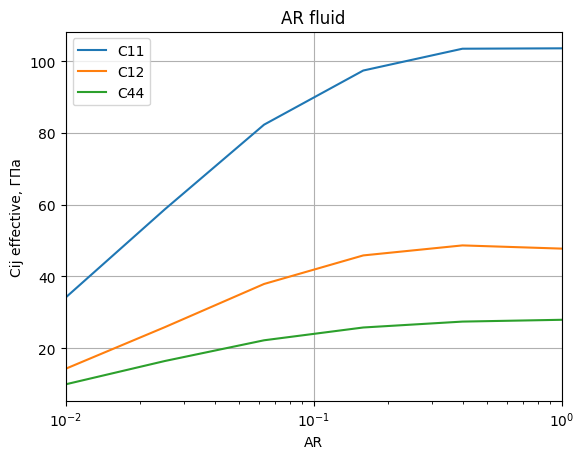

In [49]:
plt.plot(1/AR_loop, c11_air, label='C11')
plt.plot(1/AR_loop, c12_air, label='C12')
plt.plot(1/AR_loop, c44_air, label='C44')
plt.xscale("log")
plt.xlabel('AR')

plt.ylabel('Cij effective, ГПа')
plt.title ('AR fluid')
plt.xlim(10**-2, 10**0)

plt.grid()
plt.legend()

In [70]:
data_air = {
    'C11': c11_air,
    'C12': c12_air,
    'C44': c44_air
}

inversion_air = pd.DataFrame(data_air)
inversion_air['Density (water)'] = data['Density (water)'][0]

density = 2.572247

Vp_exp, Vs_exp = data['Vp air'][0], data['Vs air'][0]

inversion_air['Vp air'] = inversion_air[['C11']].apply(lambda x: np.sqrt(x[0] / density), axis=1)
inversion_air['Vs air'] = inversion_air[['C44']].apply(lambda x: np.sqrt(x[0] / density), axis=1)
inversion_air['AR inclusion'] = 1/AR_loop
inversion_air['Diff Vp'] = inversion_air[['Vp air']].apply(lambda x: np.round(abs(x[0] - Vp_exp)/Vp_exp*100, 2), axis=1)
inversion_air['Diff Vs'] = inversion_air[['Vs air']].apply(lambda x: np.round(abs(x[0] - Vs_exp)/Vs_exp*100, 2), axis=1)

df_sorted_air = inversion_air.sort_values(by='Diff Vp')
df_sorted_air

,C11,C12,C44,Density (water),Vp air,Vs air,AR inclusion,Diff Vp,Diff Vs
4,58.719006,25.865007,16.427000,2.572247,4.777856,2.527102,0.025119,5.14,7.08
3,82.307450,37.901221,22.203114,2.572247,5.656701,2.937992,0.063096,12.30,24.49
2,97.402128,45.861194,25.770467,2.572247,6.153581,3.165227,0.158489,22.17,34.12
1,103.481699,48.652339,27.414680,2.572247,6.342719,3.264640,0.398107,25.92,38.33
0,103.591638,47.758121,27.916758,2.572247,6.346087,3.294399,1.000000,25.99,39.59
5,34.120752,14.265412,9.927670,2.572247,3.642109,1.964569,0.010000,27.69,16.76


In [71]:
data_water = {
    'C11': c11_water,
    'C12': c12_water,
    'C44': c44_water
}

inversion_water = pd.DataFrame(data_water)
inversion_water['Density (water)'] = data['Density (water)'][0]

density = 2.572247

Vp_exp, Vs_exp = data['Vp water'][0], data['Vs water'][0]

inversion_water['Vp air'] = inversion_water[['C11']].apply(lambda x: np.sqrt(x[0] / density), axis=1)
inversion_water['Vs air'] = inversion_water[['C44']].apply(lambda x: np.sqrt(x[0] / density), axis=1)
inversion_water['AR inclusion'] = 1/AR_loop
inversion_water['Diff Vp'] = inversion_water[['Vp air']].apply(lambda x: np.round(abs(x[0] - Vp_exp)/Vp_exp*100, 2), axis=1)
inversion_water['Diff Vs'] = inversion_water[['Vs air']].apply(lambda x: np.round(abs(x[0] - Vs_exp)/Vs_exp*100, 2), axis=1)

df_sorted_water = inversion_water.sort_values(by='Diff Vp')
df_sorted_water

,C11,C12,C44,Density (water),Vp air,Vs air,AR inclusion,Diff Vp,Diff Vs
4,77.344523,39.899897,18.722313,2.572247,5.483508,2.697885,0.025119,3.57,1.83
5,65.402577,38.721963,13.340307,2.572247,5.042444,2.277333,0.010000,4.76,14.05
3,89.834956,43.662922,23.086017,2.572247,5.909712,2.995837,0.063096,11.62,13.07
2,99.681659,47.730626,25.975516,2.572247,6.225171,3.177794,0.158489,17.58,19.94
0,104.266466,48.432949,27.916758,2.572247,6.366724,3.294399,1.000000,20.25,24.34
1,104.311071,49.425191,27.442940,2.572247,6.368085,3.266322,0.398107,20.28,23.28


In [91]:
fluid_list = ['air', 'water', 'oil']
ind=0

for fluid in fluid_list:
    data_fluid = {
        f'C11_{fluid}': globals()[f'c11_{fluid}'],
        f'C12_{fluid}': globals()[f'c12_{fluid}'],
        f'C44_{fluid}': globals()[f'c44_{fluid}']
    }
    globals()[f'inversion_{fluid}'] = pd.DataFrame(data_fluid)
    globals()[f'inversion_{fluid}'][f'Density ({fluid})'] = data['Density (water)'][ind]


    density = data['Density (water)'][ind]

    Vp_exp, Vs_exp = data[f'Vp {fluid}'][ind], data[f'Vs {fluid}'][ind]

    globals()[f'inversion_{fluid}'][f'Vp {fluid}'] = globals()[f'inversion_{fluid}'][[f'C11_{fluid}']].apply(lambda x: np.sqrt(x[0] / density), axis=1)
    globals()[f'inversion_{fluid}'][f'Vs {fluid}'] = globals()[f'inversion_{fluid}'][[f'C44_{fluid}']].apply(lambda x: np.sqrt(x[0] / density), axis=1)
    globals()[f'inversion_{fluid}']['AR inclusion'] = AR_loop**-1

    globals()[f'inversion_{fluid}'][f'Diff Vp {fluid}'] = globals()[f'inversion_{fluid}'][[f'Vp {fluid}']].apply(lambda x: np.round(abs(x[0] - Vp_exp)/Vp_exp*100, 2), axis=1)
    globals()[f'inversion_{fluid}'][f'Diff Vs {fluid}'] = globals()[f'inversion_{fluid}'][[f'Vs {fluid}']].apply(lambda x: np.round(abs(x[0] - Vs_exp)/Vs_exp*100, 2), axis=1)

    globals()[f'inversion_{fluid}'] = globals()[f'inversion_{fluid}'].sort_values(by=f'Diff Vp {fluid}')



In [93]:
inversion_air

,C11_air,C12_air,C44_air,Density (air),Vp air,Vs air,AR inclusion,Diff Vp air,Diff Vs air
4,58.719006,25.865007,16.427000,2.572247,4.777856,2.527102,0.025119,5.14,7.08
3,82.307450,37.901221,22.203114,2.572247,5.656702,2.937992,0.063096,12.30,24.49
2,97.402128,45.861194,25.770467,2.572247,6.153581,3.165227,0.158489,22.17,34.12
1,103.481699,48.652339,27.414680,2.572247,6.342719,3.264640,0.398107,25.92,38.33
0,103.591638,47.758121,27.916758,2.572247,6.346087,3.294399,1.000000,25.99,39.59
5,34.120752,14.265412,9.927670,2.572247,3.642110,1.964569,0.010000,27.69,16.76


In [74]:
data['AR thermal'][0], data['AO electrical'][0]

(0.066681, 0.06918309709189363)

In [59]:
df_sorted = inversion.sort_values(by='Diff Vp')
df_sorted

,C11,C12,C44,Density (water),Vp air,Vs air,AR inclusion,Diff Vp,Diff Vs
4,58.719006,25.865007,16.427000,2.459785,4.777856,2.527102,0.025119,5.144818,7.080599
3,82.307450,37.901221,22.203114,2.326067,5.656701,2.937992,0.063096,12.302982,24.491188
2,97.402128,45.861194,25.770467,2.285245,6.153581,3.165227,0.158489,22.167570,34.119772
1,103.481699,48.652339,27.414680,2.537162,6.342719,3.264640,0.398107,25.922544,38.332191
0,103.591638,47.758121,27.916758,2.572247,6.346087,3.294399,1.000000,25.989416,39.593166
5,34.120752,14.265412,9.927670,2.462813,3.642109,1.964569,0.010000,27.692889,16.755542


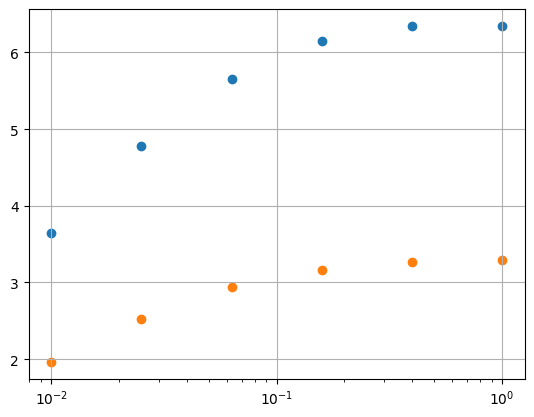

In [64]:
plt.scatter(inversion['AR inclusion'], inversion['Vp air'])
plt.scatter(inversion['AR inclusion'], inversion['Vs air'])
plt.xscale("log")
plt.grid()